# Single mode C.I.M 


### Imports and includes

In [1]:
#import Pkg; Pkg.add("QuantumOpticsBase")
import QuantumOptics
using LinearAlgebra
using Random
using Statistics
using Roots
using QuadGK
using QuantumOptics
include("homodyne.jl")

homodyne_b! (generic function with 2 methods)

### Parameters

In [2]:
ϵτ = 1.0
β = 2.0
θ = (asin∘sqrt)(0.01)
r_bs = 0.5
r_ic = 0.01

0.01

## Beamsplitter
Input state $
\left| n \right>_1 \otimes \left| m \right>_2  = \left( \hat{a}^{\dagger}_1 \otimes \mathbb{I}_2 \right)^n
\left(\mathbb{I}_1 \otimes \hat{a}^{\dagger}_2 \right)^m \left| 0 \right>_1 \otimes \left| 0 \right>_2
$

Output state $ \left| p \right>_3 \otimes \left| q \right>_4 = \left( \hat{a}^{\dagger}_3 \otimes \mathbb{I}_4 \right)^p
\left(\mathbb{I}_3 \otimes \hat{a}^{\dagger}_4 \right)^q \left| 0 \right>_3 \otimes \left| 0 \right>_4$

Unitary model of beam-splitter

$$ U_{bs} = \exp \left\{ (\arcsin r) \hat a^\dagger \hat b - \text{H.c.}  \right\} $$

### Algorithm 1

Form density matrix

$\rho_i = \left( \left| n \right>_1 \otimes \left| m \right>_2 \right)^{\dagger} \otimes \left( \left| n \right>_1 \otimes \left| m \right>_2 \right) $

Act with beam-splitter unitary

$\rho_f = U_{bs} \rho_i U_{bs}^{\dagger}$

Return tuple of partial traces

$ \left( \text{Tr}_1 \left[ \rho_f \right], \text{Tr}_2 \left[\rho_f \right] \right)$

### Algorithm 2

Act with beam-splitter unitary on product state

$\psi_{out} = U_{bs} \left| n \right>_1 \otimes \left| m \right>_2 $

Partial collapse (may be conditional on result $y$) due to measurement on second subsystem

$ \psi_{coll} =\hat{P} (y) \psi_{out} $

In [3]:
# Defining beamsplitter unitary operator (on composite state)
basis_a = FockBasis(2); basis_b = FockBasis(2)
id_a = identityoperator(basis_a)
id_b = identityoperator(basis_b)
a = destroy(basis_a) ⊗ id_b
b = id_a ⊗ destroy(basis_b)

U_out = exp( dense(asin(r_bs)* (dagger(a)*b - a*dagger(b))) )
U_in = exp( dense(asin(r_ic)* (dagger(a)*b - a*dagger(b))) );

## Crystal propagation
$$ 
\hat{H}_{cry} = \frac{i\cdot \varepsilon}{2} \hat{b} \hat{a}^{\dagger 2} + \text{H.c.}
$$
Time evolution operator
$$ U_{cry} (\tau) = e^{-\frac{i}{\hbar} \hat{H} \tau} 

In [4]:
H_cr = 1im * ϵτ * (b + id_a ⊗ (β/sqrt(2)*id_b)) * dagger(a^2)
H_cr = 0.5*(H_cr + dagger(H_cr));

### Random collapse

In [5]:
function random_collapse(ψ::Ket, ψcache::Ket, projectors, rng::AbstractRNG=Random.GLOBAL_RNG)
    Fnb = cumsum(real(expect(n,ψ)) for n in projectors)
    Fnb[end] = 1.0
    nb_samp = searchsortedlast(Fnb, rand(rng))
    ψcache .= ψ
    mul!(ψ, projectors[nb_samp+1], ψcache) #(target, op., input)
    for n in 1:nb_samp
        ψcache .= ψ
        mul!(ψ, b, ψcache)
    end
    normalize!(ψ)
    return nb_samp
end

random_collapse (generic function with 2 methods)

## Discrete algorithm
### Roundtrip
1. Crystal propagation
2. Reset ancilla & Loss & Reset ancilla
3. Homodyne measurement
4. Reset ancilla & Loss & Reset ancilla
5. Feedback injection

In [9]:
function CIM_roundtrip!(ψ_1::Ket, ψ_2::Ket, H_cr::Operator, U_out::Operator, U_in::Operator, y, r_ic, basis_a::Basis, basis_b::Basis, hom::Homodyne, projectors)   
    # crystal propagation (result in ψ_2)
    _, (_,ψ_2) = timeevolution.schroedinger([0,1], ψ_1, H_cr)
    # loss 1
    #TODO: implement cavity loss

    # Homodyne measurement (result in ψ_1)
    ψ_2 = U_out * ψ_2
    w = homodyne_b!(hom, ψ_2, Random.GLOBAL_RNG)
    # loss 2
    #TODO: implement cavity loss

    # Feedback injection
    
    id_1 = identityoperator(basis_a)
    D_α = displace(basis_b, y(w)/r_ic)
    U_ic = id_1 ⊗ D_α
    ψ_1 = U_ic * ψ_2
    clicks = random_collapse(ψ_1, ψ_2, projectors)
    return w
end

CIM_roundtrip! (generic function with 2 methods)

In [13]:
# x = Ket(basis_a, [1, 1, 1])
# y = Ket(basis_b, [1, 0, 0]) # vacum state
hom = Homodyne(basis_a, basis_b)
projectors = [identityoperator(basis_a) ⊗ projector(fockstate(basis_b,i)) for i in 0:basis_b.N];
ψ_init = fockstate(basis_a,0) ⊗ fockstate(basis_b,0)
ancilla = deepcopy(ψ_init)
nbr_roundtrips = 50
w = zeros(nbr_roundtrips)
for i in 1:nbr_roundtrips
    w[i] = CIM_roundtrip!(ψ_init, ancilla, H_cr, U_out, U_in, w -> w / 10, r_ic, basis_a, basis_b, hom, projectors)
end


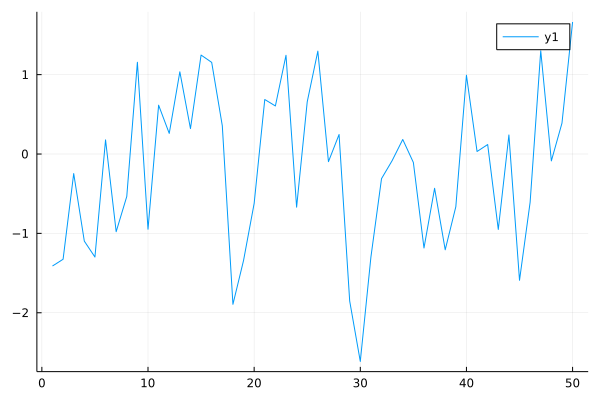

In [15]:
using Plots
plot(w)

# Testing

In [ ]:
function beam_splitter(input_a, input_b, r)
    #Ψ = input_a ⊗ input_b
    #ρ = Ψ ⊗ dagger(Ψ)
    ρ = (input_a ⊗ input_b) ⊗ dagger(input_a ⊗ input_b)

    id_a = identityoperator(input_a.basis)
    id_b = identityoperator(input_b.basis)
    a = destroy(input_a.basis) ⊗ id_b
    b = id_a ⊗ destroy(input_b.basis)

    bs_unitary = exp( dense(asin(r)* (dagger(a)*b - a*dagger(b))) ) # This is constant, move out

    result_state = bs_unitary * ρ * dagger(bs_unitary)

    # This results in an operator...
    result_a = ptrace(result_state, 1)
    result_b = ptrace(result_state, 2)

    return (result_a, result_b)
end

function beam_splitter_2(input_a, input_b, r) #take a state & op. do it inplace
    # take in the product state
    Ψ = input_a ⊗ input_b

    id_a = identityoperator(input_a.basis)
    id_b = identityoperator(input_b.basis)
    a = destroy(input_a.basis) ⊗ id_b
    b = id_a ⊗ destroy(input_b.basis)

    bs_unitary = exp( dense(asin(r)* (dagger(a)*b - a*dagger(b))) ) # This is constant, move out

    result_state = bs_unitary * Ψ

    return result_state
end

# Seems to use more memory in addition to being slow (ˇ-ˇ)
function lazy_beam_splitter(input_a, input_b, r)
    common_basis = tensor(input_a.basis, input_b.basis)
    #Ψ = input_a ⊗ input_b
    #ρ = Ψ ⊗ dagger(Ψ)
    ρ = (input_a ⊗ input_b) ⊗ dagger(input_a ⊗ input_b)

    a = LazyTensor(common_basis, [1], (destroy(input_a.basis),))
    b = LazyTensor(common_basis, [2], (destroy(input_b.basis),))

    bs_unitary = exp(asin(r)*dense( LazySum(LazyProduct(dagger(a), b), -LazyProduct(a, dagger(b))) ))

    result_state = dense( LazyProduct( bs_unitary, ρ, dagger(bs_unitary) ) )
    #result_state = bs_unitary * ρ * dagger(bs_unitary)

    # This results in an operator...
    result_a = ptrace(result_state, 1)
    result_b = ptrace(result_state, 2)

    return (result_a, result_b)
end

In [13]:
using BenchmarkTools

N = 3
my_basis = FockBasis(2)
# x = Ket(my_basis, 2*rand(N)-ones(N))
# y = Ket(my_basis, 2*rand(N)-ones(N))
x = Ket(my_basis, [0, 1, 0])
y = Ket(my_basis, [1, 0, 0]) # vacum state

r= 1/sqrt(2)
Ψ = x ⊗ y

hom = Homodyne(x.basis, y.basis)


result_state = bs_unitary * Ψ
println(result_state)
x_0 = homodyne_b!(hom, result_state, Random.GLOBAL_RNG)
println(x_0)
println(result_state)
# @btime beam_splitter(x, y, 0.5)
# println("---")
# @btime lazy_beam_splitter(x, y, 0.5)


Ket(dim=9)
  basis: [Fock(cutoff=2) ⊗ Fock(cutoff=2)]
                 0.0 + 0.0im
  0.7071067811865477 + 0.0im
                 0.0 + 0.0im
 -0.7071067811865475 + 0.0im
                 0.0 + 0.0im
                 0.0 + 0.0im
                 0.0 + 0.0im
                 0.0 + 0.0im
                 0.0 + 0.0im
-0.23399198539460958
Ket(dim=9)
  basis: [Fock(cutoff=2) ⊗ Fock(cutoff=2)]
 0.31416040381973315 + 0.0im
  0.9493699177200752 + 0.0im
                 0.0 + 0.0im
                 0.0 + 0.0im
                 0.0 + 0.0im
                 0.0 + 0.0im
                 0.0 + 0.0im
                 0.0 + 0.0im
                 0.0 + 0.0im
